# Script to analyze the gene expression over different bins
### Genome Analysis Project, VT24

**Last Changed:** 2024-04-29

## Read the data

Look at the gene expression in the different bins/environments

In [1]:
# Import the necessary packages
import os
import pandas as pd

In [2]:
# Define the path to the directory containing the data files (.tsv format)
directory = '/Users/claranordquist/Documents/Universitetet/VT/Genome_Analysis/Lab_Project/Feature_analysis/'

# Create a dictionary where all the dataframes will be stored for each bin
# Create another dictionary where the data is pooled so that there is just one dataset for the high (SRR4342137) and one for the low oxygen (SRR4342139) environment
bin_dataframes = {}
# env_dataframes = {'High':pd.DataFrame(), 'Low':pd.DataFrame()}

# Loop over the files in the input directory and pick those that end with .tsv
# For those, read the files and make them into dataframes
for file in os.listdir(directory):
    if file.endswith('.tsv'):
        basename = file[:-4]
        bin_dataframes[basename] = pd.read_table(os.path.join(directory, file), sep='\t')
        bin_dataframes[basename].insert(0, 'Count', bin_dataframes[basename].index)
        bin_dataframes[basename].insert(0, 'Bin', basename)

        # if basename.endswith('SRR4342137'):
        #     env_dataframes['High'] = pd.concat([env_dataframes['High'], bin_dataframes[basename]], axis=0, ignore_index=True)
        # else:
        #     env_dataframes['Low'] = pd.concat([env_dataframes['Low'], bin_dataframes[basename]], axis=0, ignore_index=True)

In [3]:
# This can be used to merge rows that are from the same feature, if multiple bins would show the same feature 
# Don't know if this is necessary though?
# aggregate_function = {"index":'sum', "Gene_ID":'first', "ftype":'first', "length_bp":'first', "gene":'first', "EC_number":'first', "COG":'first', "Product":'first'}

# for env, data in env_dataframes.items():
#     data = data.groupby(data['Gene_ID']).aggregate(aggregate_function)

## Basic Analysis: Heatmap
Display the gene expression through a heatmap

In [35]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Pool the data into one dataframe with three columns
# Drop the rows with NaN values (= genes without names)
# Bin (4_low, 4_high, 15_low, 15_high, ...)
# Gene (Preferred_name)
# Count (N° RNA counts)
heatmap_dataframe = pd.concat([bin_dataframes[x][['Bin', 'Count', 'Preferred_name']] for x in bin_dataframes.keys()], axis=0)
heatmap_dataframe.reset_index(drop=True, inplace=True)
heatmap_dataframe.drop(heatmap_dataframe.loc[heatmap_dataframe['Preferred_name'] == '-'].index, inplace=True)

# Convert it to a pivot table telling how I want the heatmap
# Columns = Genes
# Rows = Bins
# Values = Count numbers
pivot_table = pd.pivot_table(data=heatmap_dataframe, columns='Preferred_name', index='Bin', values='Count')

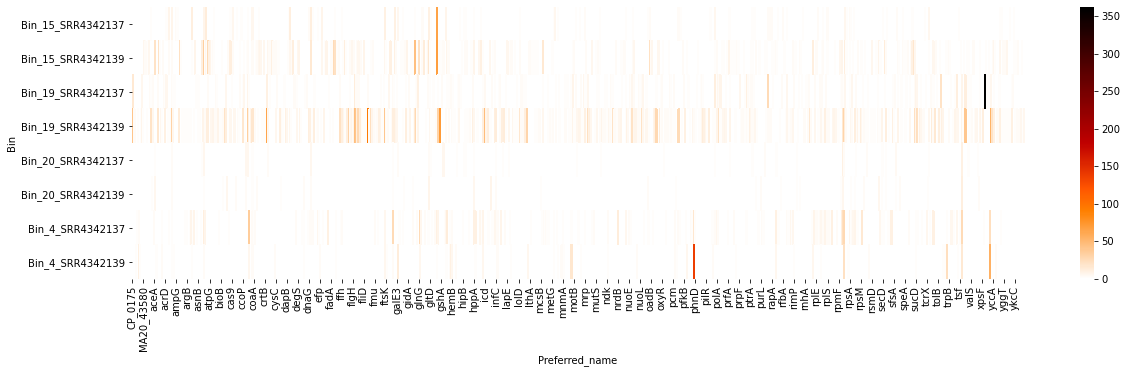

In [50]:
# Plot the heatmap
plt.figure(figsize = (20,5))
sns.heatmap(pivot_table, cmap='gist_heat_r', vmin=0)
plt.show()

## Extra Analysis

### COG Categories

In [4]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# First, create new datasets with only the bin name, count, and COG category
# Reset the index
bins_COG = {}
for sample, data in bin_dataframes.items():
    bins_COG[sample] = data[['Bin', 'Count', 'COG_category']]
    bins_COG[sample].reset_index(drop=True, inplace=True)

# Remove all genes that don't have a COG category
for data in bins_COG.values():
    data.drop(data.loc[data['COG_category'] == '-'].index, inplace=True)

# Collect all values for the individual COG codes, so that they are in the same row (one row per category)
aggregate_function = {"Bin":'first', "Count":'sum', "COG_category":'first'}
for sample in bins_COG.keys():
    bins_COG[sample] = bins_COG[sample].groupby(bins_COG[sample]['COG_category']).aggregate(aggregate_function)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_16030/981294619.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(data.loc[data['COG_category'] == '-'].index, inplace=True)


In [6]:
count_dict = {'A':0, 'B':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'J':0, 'K':0, 'L':0,
              'M':0, 'N':0, 'O':0, 'P':0, 'Q':0, 'T':0, 'U':0, 'V':0, 'Y':0, 'Z':0, 'R':0, 'S':0}

In [7]:
# Resolve all genes which have multiple COG categories
# Remove those entries, and replace them with one for each COG category
# Store the results in a dictionary
dictionaries = {}
for sample in bins_COG.keys():
    dictionaries[sample] = count_dict.copy()

    # Iterate over all the rows in the dataframe
    # Select the value in the COG_category column
    # If it's just one category, store it as it is
    # Otherwise, split it into its individual categories and add to the dictionary

    for index, row in bins_COG[sample].iterrows():
        COG = row['COG_category']
        if len(COG) == 1:
            dictionaries[sample][COG] = bins_COG[sample].loc[COG]['Count']
        
        if len(COG) > 1:
            categories = list(COG)
            
            for category in categories:
                dictionaries[sample][category] += 1

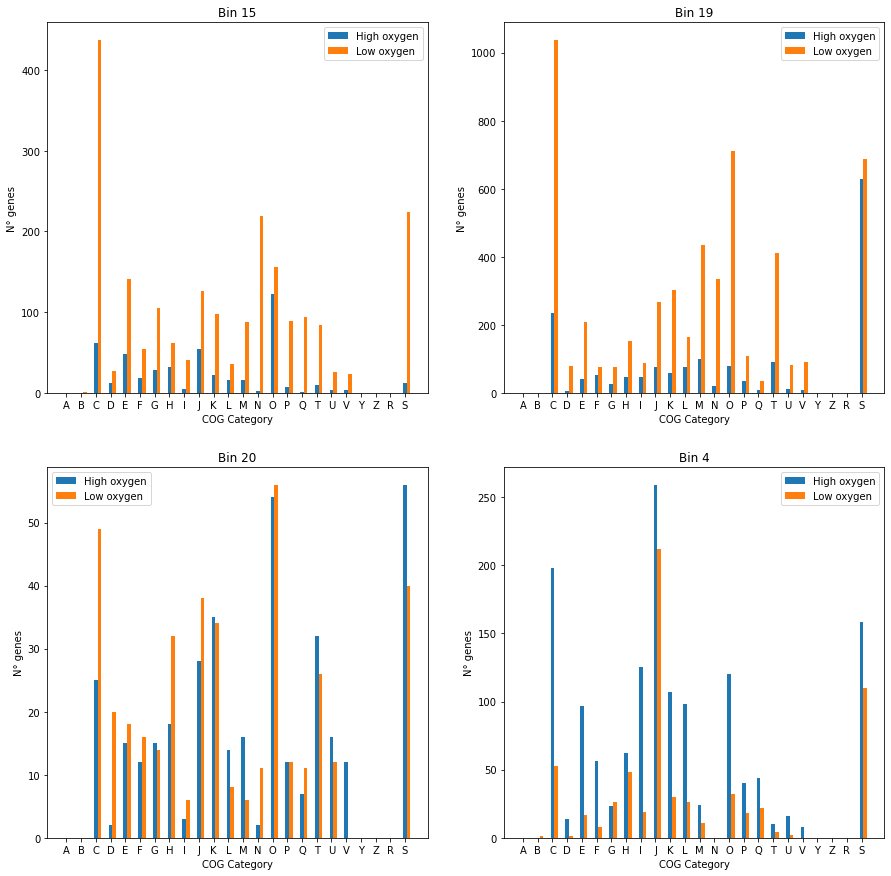

In [8]:
# Plot the results
x_values = np.arange(len(count_dict.keys()))
x_labels = [a for a in count_dict.keys()]

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.title('Bin 15')
plt.bar(x_values, dictionaries['Bin_15_SRR4342137'].values(), width=0.25, label='High oxygen')
plt.bar(x_values + 0.25, dictionaries['Bin_15_SRR4342139'].values(), width=0.25, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('N° genes')

plt.subplot(2, 2, 2)
plt.title('Bin 19')
plt.bar(x_values, dictionaries['Bin_19_SRR4342137'].values(), width=0.25, label='High oxygen')
plt.bar(x_values + 0.25, dictionaries['Bin_19_SRR4342139'].values(), width=0.25, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('N° genes')

plt.subplot(2, 2, 3)
plt.title('Bin 20')
plt.bar(x_values, dictionaries['Bin_20_SRR4342137'].values(), width=0.25, label='High oxygen')
plt.bar(x_values + 0.25, dictionaries['Bin_20_SRR4342139'].values(), width=0.25, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('N° genes')

plt.subplot(2, 2, 4)
plt.title('Bin 4')
plt.bar(x_values, dictionaries['Bin_4_SRR4342137'].values(), width=0.25, label='High oxygen')
plt.bar(x_values + 0.25, dictionaries['Bin_4_SRR4342139'].values(), width=0.25, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('N° genes')

plt.show()